In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn.feature_selection
import torch

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

from sklearn.linear_model import LinearRegression


In [2]:
data = pd.read_csv('train.csv')

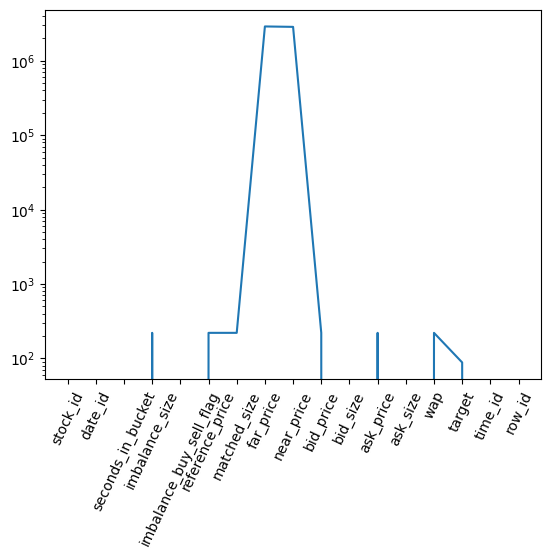

In [3]:
how_many_nas = []

for column in data.columns:
    how_many_nas.append(data[data[column].isna()].shape[0])

plt.plot(how_many_nas)
plt.xticks(np.arange(0, len(data.columns),1),data.columns, rotation=65)
plt.yscale('log')

In [4]:
data = data[data['wap'].notna()]

(0.0, 100.0)

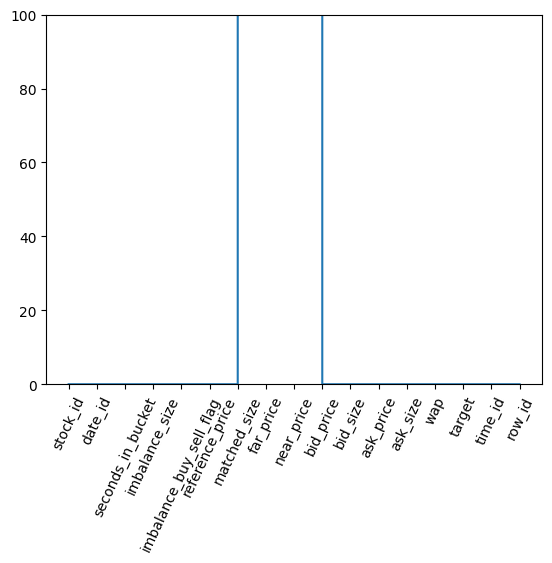

In [5]:
how_many_nas = []

for column in data.columns:
    how_many_nas.append(data[data[column].isna()].shape[0])

plt.plot(how_many_nas)
plt.xticks(np.arange(0, len(data.columns),1),data.columns, rotation=65)
plt.ylim(0,100)

In [6]:
data['imbalance'] = data['imbalance_size']*data['imbalance_buy_sell_flag']

In [7]:
train, val = data[data['date_id']<400], data[data['date_id']>=400]
train = train.drop(['row_id'], axis=1)


val = val.drop(['row_id'], axis=1)

quantitative_features = ['seconds_in_bucket', 
                         'imbalance', 
                         'reference_price', 
                         'matched_size', 
                         'bid_price', 
                         'bid_size', 
                         'ask_price', 
                         'ask_size', 
                         'wap']

In [8]:
autocorr_over_dates = {}
cint_over_dates = {}

for group_name, df_group in train.groupby(['date_id', 'stock_id']):
    autocorr_over_dates[group_name], cint_over_dates[group_name] = pacf(df_group['wap'], alpha=0.05)

In [9]:
stock_return_array = np.zeros((train['stock_id'].nunique(), train['date_id'].nunique(), train['seconds_in_bucket'].nunique()))
index_return_array = np.zeros((train['stock_id'].nunique(), train['date_id'].nunique(), train['seconds_in_bucket'].nunique()))



for group_name, df_group in train.groupby(['stock_id', 'date_id']):
    df_group['stock_return'] = (df_group['wap'].shift(-6)/df_group['wap'] - 1)*10000
    df_group['index_return'] = (df_group['stock_return'] - df_group['target'])
    stock_return_array[group_name[0], group_name[1]] = df_group['stock_return'].values
    index_return_array[group_name[0], group_name[1]] = df_group['index_return'].values
    

In [10]:
index_returns = np.asarray([np.mean(index_return_array[:,i,0], axis=0) for i in range(train['date_id'].nunique())])

In [11]:
stock_returns = stock_return_array[:,:,0]

In [12]:
lr = LinearRegression()
lr.fit(np.transpose(stock_returns), index_returns)

LinearRegression()

In [13]:
index_weights = lr.coef_
index_weights_df = pd.DataFrame.from_dict({'stock_id': [i for i in range(200)], 'weight': [index_weights[i] for i in range(200)]})
train_with_weights = pd.merge(train, index_weights_df, on='stock_id')
val_with_weights   = pd.merge(val,   index_weights_df, on='stock_id')


In [14]:
autocorr = np.zeros((len(autocorr_over_dates.keys()),18))

lower_range = np.zeros((len(autocorr_over_dates.keys()),18))
upper_range = np.zeros((len(autocorr_over_dates.keys()),18))

counter = 0
for index, key in enumerate(autocorr_over_dates.keys()):
    
    if not sum(abs(autocorr_over_dates[key])>1)>=1 and autocorr_over_dates[key].shape[0]==18: 
        counter+=1
        autocorr[index,:] = autocorr_over_dates[key]
        lower_range[index,:] = cint_over_dates[key][:,0]
        upper_range[index,:] = cint_over_dates[key][:,1]
    else:
        autocorr[index,:] = np.asarray(18*[np.nan])
        lower_range[index,:] = np.asarray(18*[np.nan])
        upper_range[index,:] = np.asarray(18*[np.nan])

Text(0.5, 0, 'Lag')

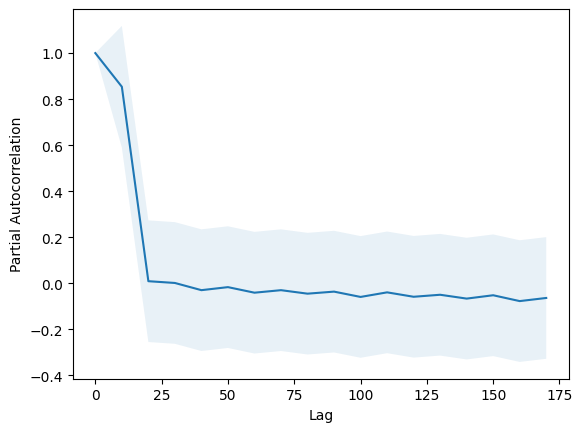

In [15]:
plt.plot(np.arange(0,180,10), np.nanmean(autocorr, axis=0) )
plt.fill_between(np.arange(0,180,10), 
                 np.nanmean(lower_range, axis=0) , 
                 np.nanmean(upper_range, axis=0) ,
                 alpha=0.1)


plt.ylabel('Partial Autocorrelation')
plt.xlabel('Lag')
#plt.ylim(-1,1)

In [16]:
for feature in quantitative_features:
    for i in range(1, 7):
        train_with_weights['shifted by '+str(i) + " " + feature] = train_with_weights.groupby(['date_id', 'stock_id'])[feature].shift(i)
        val_with_weights['shifted by '+str(i) + " "+feature] = val_with_weights.groupby(['date_id', 'stock_id'])[feature].shift(i)

In [17]:
train_with_weights['new_target'] = train_with_weights.groupby(['date_id', 'stock_id'])['wap'].shift(-6)
val_with_weights['new_target'] = val_with_weights.groupby(['date_id', 'stock_id'])['wap'].shift(-6)

In [18]:
training_features = quantitative_features.copy()
training_features.extend(['shifted by {} '.format(i)+feature for feature in quantitative_features for i in range(1,7)])

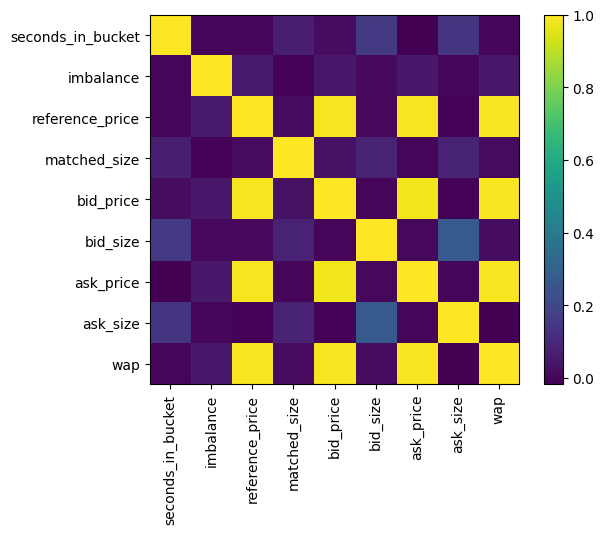

In [19]:
training_features_and_target = training_features + ['target']
training_features_and_new_target = training_features + ['new_target']
plt.imshow(train_with_weights[quantitative_features].corr())
plt.xticks(np.arange(0,len(quantitative_features)), quantitative_features, rotation=90)
plt.yticks(np.arange(0,len(quantitative_features)), quantitative_features, rotation=0)
plt.colorbar()
plt.show()

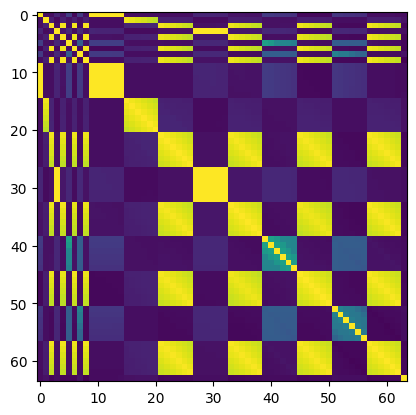

In [20]:
plt.imshow(train_with_weights[training_features_and_target].corr())

In [21]:
one_hot_stock_id_train = pd.get_dummies(train_with_weights['stock_id'], dtype=float)
one_hot_stock_id_val = pd.get_dummies(val_with_weights['stock_id'], dtype=float)

train_one_hot_stocks = train_with_weights.join(one_hot_stock_id_train)
val_one_hot_stocks = val_with_weights.join(one_hot_stock_id_val)

training_features_and_one_hot_and_new_target = training_features_and_new_target.copy()
training_features_and_one_hot_and_new_target.extend([i for i in range(200)])

training_features_and_one_hot = training_features.copy()
training_features_and_one_hot.extend([i for i in range(200)])

In [22]:
training_data_for_regressor = train_with_weights[training_features_and_target].dropna()

x_train = training_data_for_regressor[training_features]
y_train = training_data_for_regressor['target']

val_data_for_regressor = val_with_weights[training_features_and_target].dropna()

x_val = val_data_for_regressor[training_features]
y_val = val_data_for_regressor['target']

xgb_r = xgb.XGBRegressor(n_estimators=100, objective = 'reg:absoluteerror', eval_metric='mae')

xgb_r.fit(x_train, y_train)

print(1/y_val.shape[0] * np.sum(abs(xgb_r.predict(x_val)-y_val)))

5.881909168843


In [23]:
quantitative_features_and_new_target = quantitative_features.copy()
quantitative_features_and_new_target.append('new_target')

In [24]:
training_data_for_regressor = train_with_weights[quantitative_features_and_new_target].dropna()

x_train = training_data_for_regressor[quantitative_features]
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val_with_weights[quantitative_features_and_new_target].dropna()

x_val = val_data_for_regressor[quantitative_features]
y_val = val_data_for_regressor['new_target']

xgb_r = xgb.XGBRegressor(n_estimators=100, objective = 'reg:absoluteerror', eval_metric='mae')

xgb_r.fit(x_train, y_train)

print(xgb_r.score(x_val, y_val))

print(1/y_val.shape[0] * np.sum(np.abs(y_val - xgb_r.predict(x_val))))

0.7806515333712675
0.0006935665346231938


In [62]:
training_data_for_regressor = train_with_weights[quantitative_features_and_new_target].dropna()

x_train = training_data_for_regressor[quantitative_features].values
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val_with_weights[quantitative_features_and_new_target].dropna()

x_val = val_data_for_regressor[quantitative_features].values
y_val = val_data_for_regressor['new_target']

lr = LinearRegression()

lr.fit(x_train, y_train)

print(lr.score(x_val, y_val))

print(1/y_val.shape[0] * np.sum(np.abs(y_val - lr.predict(x_val))))

0.8153236554975143
0.0006869893323056459


In [26]:
lr_for_stock = {}
for stock_id in train_with_weights['stock_id'].unique():
    training_data_for_regressor = train_with_weights[train_with_weights['stock_id']==stock_id][quantitative_features_and_new_target].dropna()

    x_train = training_data_for_regressor[quantitative_features].values
    y_train = training_data_for_regressor['new_target']
    
    val_data_for_regressor = val_with_weights[val_with_weights['stock_id']==stock_id][quantitative_features_and_new_target].dropna()
    
    x_val = val_data_for_regressor[quantitative_features].values
    y_val = val_data_for_regressor['new_target']

    lr_for_stock[stock_id] =  LinearRegression()

    lr_for_stock[stock_id].fit(x_train, y_train)

    print(lr_for_stock[stock_id].score(x_val, y_val))
    
    print(1/y_val.shape[0] * np.sum(np.abs(y_val - lr_for_stock[stock_id].predict(x_val))))

0.8250058077910019
0.0004551618028418902
0.8162193928350857
0.0008740180402584065
0.8237336747846211
0.0007994123001554391
0.7963229054218508
0.00044358343670409823
0.7878179156651556
0.0004742464596990396
0.7757370086768456
0.0008186630306235499
0.8003005101334457
0.0006840202633179663
0.8146464490763642
0.0007391368289886106
0.8009188288547453
0.0005762516376057967
0.7676302047141514
0.0006172695482213596
0.8374187161428641
0.0005270642080260079
0.8105649997734056
0.0011184835136825314
0.7721182402874295
0.000441402246891694
0.8602393736528597
0.0006532030459369359
0.8237072621540931
0.0006246812764828766
0.7927935228415615
0.0006512127426441428
0.790745573629832
0.0007270841460180359
0.7942729382184777
0.0007440233297652711
0.7738436641393147
0.0008896129162441911
0.7779305724142482
0.0007541448720853797
0.7741131779508135
0.0005864308328301816
0.7613433237634704
0.0005417693467066145
0.8346559118398968
0.000831106523217313
0.8420485366668559
0.0006602545319593401
0.8224827042828055

In [32]:
val_with_weights['stock_prediction_per_stock'] = val_with_weights.apply(
    lambda row: lr_for_stock[row['stock_id']].predict(row[quantitative_features].values.reshape(1,-1))[0], axis=1)

val_with_weights['stock_prediction_all_stocks'] = lr.predict(val_with_weights[quantitative_features])

/Users/hiroku007/miniforge3/envs/optiver/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [33]:
print(np.nanmean(np.abs(val_with_weights['new_target'] - val_with_weights['stock_prediction_per_stock'])))
print(np.nanmean(np.abs(val_with_weights['new_target'] - val_with_weights['stock_prediction_all_stocks'])))


0.0006861869678301604
0.0006869893323056458


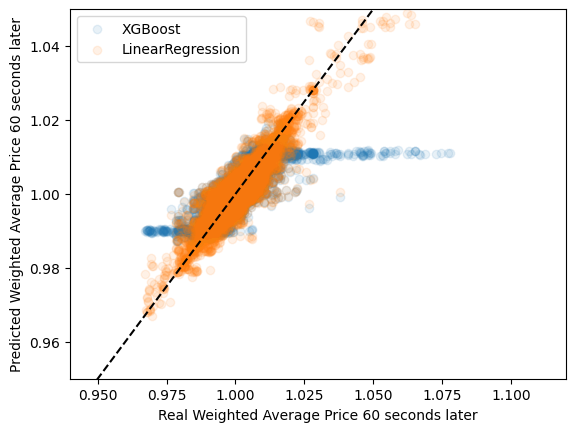

In [36]:
plt.scatter(y_val, xgb_r.predict(x_val), alpha=0.1, label = 'XGBoost')
plt.scatter(y_val, lr.predict(x_val), alpha=0.1, label = 'LinearRegression')
plt.legend(loc='best')

plt.plot([-1,2],[-1,2], color='black', ls='--')
plt.xlim(0.94, 1.12)
plt.ylim(0.95,1.05)
plt.xlabel('Real Weighted Average Price 60 seconds later')
plt.ylabel('Predicted Weighted Average Price 60 seconds later')
plt.show()

In [37]:
from tqdm import tqdm

index_df = pd.DataFrame()

for group, df_group in tqdm(train_with_weights.groupby(['date_id', 'seconds_in_bucket'])):

    index_df_second = pd.DataFrame()
    
    for feature in df_group.columns:
        if feature!='seconds_in_bucket' and feature!='date_id':
            index_df_second[feature] = [(df_group[feature]*df_group['weight']/df_group['weight'].sum()).sum()]
    index_df_second['seconds_in_bucket'] = [df_group['seconds_in_bucket'].iloc[0]]
    index_df_second['date_id']           = [df_group['date_id'].iloc[0]]
    
    index_df = pd.concat([index_df, index_df_second])
index_df_for_training = index_df[(index_df['seconds_in_bucket']>=60) & (index_df['seconds_in_bucket']<=480)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22000/22000 [03:58<00:00, 92.25it/s]


In [38]:
index_df_val = pd.DataFrame()

for group, df_group in tqdm(val_with_weights.groupby(['date_id', 'seconds_in_bucket'])):

    index_df_second = pd.DataFrame()
    
    for feature in df_group.columns:
        if feature!='seconds_in_bucket' and feature!='date_id':
            index_df_second[feature] = [(df_group[feature]*df_group['weight']/df_group['weight'].sum()).sum()]
    index_df_second['seconds_in_bucket'] = [df_group['seconds_in_bucket'].iloc[0]]
    index_df_second['date_id']           = [df_group['date_id'].iloc[0]]
    
    index_df_val = pd.concat([index_df_val, index_df_second])
    
index_df_for_val = index_df_val[(index_df_val['seconds_in_bucket']>=60) & (index_df_val['seconds_in_bucket']<=480)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [00:50<00:00, 88.03it/s]


In [46]:
index_df_for_training = index_df[(index_df['seconds_in_bucket']<=480)]
index_df_for_val = index_df_val[(index_df_val['seconds_in_bucket']<=480)]

In [70]:
from sklearn.linear_model import LinearRegression

training_data_for_regressor = index_df_for_training[quantitative_features_and_new_target].dropna()

index_x_train = training_data_for_regressor[quantitative_features].values
index_y_train = training_data_for_regressor['new_target']

val_data_for_regressor = index_df_for_val[quantitative_features_and_new_target].dropna()

index_x_val = val_data_for_regressor[quantitative_features].values
index_y_val = val_data_for_regressor['new_target']

index_lr = LinearRegression()
index_lr.fit(index_x_train, index_y_train)
print(index_lr.score(index_x_val, index_y_val))
print(1/index_y_val.shape[0] * np.sum(np.abs(index_y_val - index_lr.predict(index_x_val))))

0.818482746601589
0.00035942358760625813


In [90]:
final_train_data = train_with_weights[quantitative_features + ['target'] + ['new_target'] + ['date_id']]

In [49]:
final_validation_data = val_with_weights[quantitative_features + ['target']+['new_target'] + ['date_id']]

In [91]:
index_df_relevant = index_df[all_relevant_features]
index_df_relevant = index_df_relevant.rename(columns = {feature: 'index '+feature for feature in quantitative_features_and_new_target})
index_df_relevant = index_df_relevant.rename(columns = {'index seconds_in_bucket':'seconds_in_bucket'})

In [50]:
all_relevant_features = quantitative_features_and_new_target + ['date_id']
index_df_val_relevant = index_df_val[all_relevant_features]

In [51]:
final_validation_data.dtypes

seconds_in_bucket      int64
imbalance            float64
reference_price      float64
matched_size         float64
bid_price            float64
bid_size             float64
ask_price            float64
ask_size             float64
wap                  float64
target               float64
new_target           float64
date_id                int64
dtype: object

In [52]:
index_df_val_relevant = index_df_val_relevant.rename(columns = {feature: 'index '+feature for feature in quantitative_features_and_new_target})
index_df_val_relevant = index_df_val_relevant.rename(columns = {'index seconds_in_bucket':'seconds_in_bucket'})

In [53]:
index_df_val_relevant

,seconds_in_bucket,index imbalance,index reference_price,index matched_size,index bid_price,index bid_size,index ask_price,index ask_size,index wap,index new_target,date_id
0,0,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388,400
0,10,8.092764e+06,1.000128,6.049426e+07,0.999876,46203.343951,1.000351,42534.000055,1.000137,0.999195,400
0,20,8.083373e+06,0.999988,6.093939e+07,0.999749,42314.892838,1.000187,34455.585384,0.999966,0.999408,400
0,30,7.987118e+06,1.000034,6.099839e+07,0.999819,37890.126880,1.000244,41326.188434,1.000017,0.999344,400
0,40,7.951866e+06,0.999771,6.098977e+07,0.999557,38784.619192,0.999945,38860.657205,0.999747,0.999316,400
...,...,...,...,...,...,...,...,...,...,...,...
0,500,-1.724128e+06,0.998861,1.738187e+08,0.998738,108400.892522,0.998992,138423.040159,0.998855,0.000000,480
0,510,-1.863924e+06,0.998896,1.737329e+08,0.998774,137875.524898,0.999016,249450.053905,0.998894,0.000000,480
0,520,-1.331615e+06,0.998824,1.737816e+08,0.998703,112064.081727,0.998951,156420.575902,0.998812,0.000000,480
0,530,-1.461910e+06,0.998829,1.741060e+08,0.998702,120027.422083,0.998944,255218.023642,0.998808,0.000000,480


In [54]:
final_validation_data.shape

(890945, 12)

In [92]:
merged_index_and_stocks_train_data = pd.merge(final_train_data, index_df_relevant, on = ['seconds_in_bucket', 'date_id'])

In [93]:
merged_index_and_stocks_train_data['prediction'] = merged_index_and_stocks_train_data.apply(
    lambda row: 10000 * (
        lr.predict(row[quantitative_features].values.reshape(1,-1))/row['wap'] - index_lr.predict(row[index_quantitative_features].values.reshape(1,-1))/row['index wap']
    )[0]
    , axis=1
)

In [96]:
mean_value = np.nanmean(merged_index_and_stocks_train_data['target'])

rsquared = 1 - np.nanmean(
    (merged_index_and_stocks_train_data['prediction'] - merged_index_and_stocks_train_data['target'])**2)/np.nanmean(
    (mean_value - merged_index_and_stocks_train_data['target'])**2
)

Text(0.5, 1.0, 'R^2 is 0.023514258757905138')

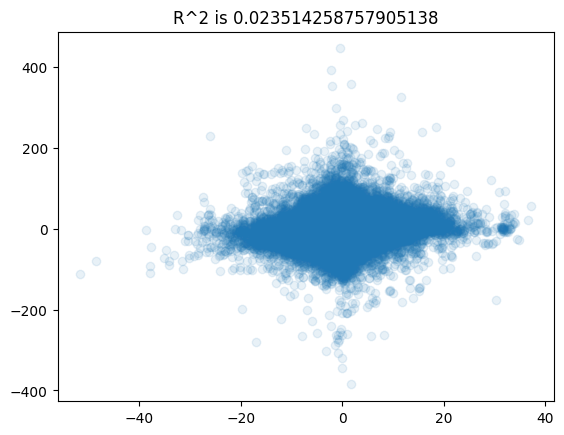

In [97]:
plt.scatter(merged_index_and_stocks_train_data['prediction'], merged_index_and_stocks_train_data['target'], alpha=0.1)
plt.title('R^2 is '+str(rsquared))

In [56]:
merged_index_and_stocks_validation_data = pd.merge(final_validation_data, index_df_val_relevant, on = ['seconds_in_bucket', 'date_id'])

In [57]:
merged_index_and_stocks_validation_data[['target','new_target','index new_target']]

,target,new_target,index new_target
0,0.050068,0.999393,0.999388
1,-10.010004,0.998387,0.999388
2,7.070303,1.000095,0.999388
3,3.780127,0.999766,0.999388
4,1.590252,0.999547,0.999388
...,...,...,...
890940,2.310276,NaN,0.000000
890941,-8.220077,NaN,0.000000
890942,1.169443,NaN,0.000000
890943,-1.540184,NaN,0.000000


In [58]:
merged_index_and_stocks_validation_data

,seconds_in_bucket,imbalance,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,...,date_id,index imbalance,index reference_price,index matched_size,index bid_price,index bid_size,index ask_price,index ask_size,index wap,index new_target
0,0,13964576.49,0.999454,10020705.20,0.999648,10312.00,1.000521,15275.08,1.000000,0.050068,...,400,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388
1,0,2003321.99,0.998651,1539364.28,0.998065,25527.00,1.002580,34190.00,1.000000,-10.010004,...,400,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388
2,0,-1918830.43,1.000470,5088261.76,0.999974,3771.45,1.001236,179925.30,1.000000,7.070303,...,400,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388
3,0,6350001.93,1.000143,32587929.09,0.999964,9777.00,1.000731,196081.38,1.000000,3.780127,...,400,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388
4,0,5551852.14,0.999428,7007913.42,0.999255,26022.00,1.000119,4167.12,1.000000,1.590252,...,400,1.045860e+07,0.999883,5.839232e+07,0.999654,34409.940488,1.000314,35516.432117,1.000000,0.999388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890940,540,-2440722.89,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,...,480,-1.106609e+06,0.998791,1.742885e+08,0.998654,153795.849550,0.998899,263309.210901,0.998756,0.000000
890941,540,-349510.47,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,...,480,-1.106609e+06,0.998791,1.742885e+08,0.998654,153795.849550,0.998899,263309.210901,0.998756,0.000000
890942,540,0.00,0.995789,12725436.10,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,...,480,-1.106609e+06,0.998791,1.742885e+08,0.998654,153795.849550,0.998899,263309.210901,0.998756,0.000000
890943,540,1000898.84,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,...,480,-1.106609e+06,0.998791,1.742885e+08,0.998654,153795.849550,0.998899,263309.210901,0.998756,0.000000


In [59]:
index_quantitative_features_and_new_target = ['index '+feature for feature in quantitative_features_and_new_target]

In [67]:
index_quantitative_features = ['index ' + feature for feature in quantitative_features]
index_quantitative_features[0] = 'seconds_in_bucket'
index_quantitative_features

['seconds_in_bucket',
 'index imbalance',
 'index reference_price',
 'index matched_size',
 'index bid_price',
 'index bid_size',
 'index ask_price',
 'index ask_size',
 'index wap']

In [74]:
merged_index_and_stocks_validation_data['prediction'] = merged_index_and_stocks_validation_data.apply(
    lambda row: 10000 * (
        lr.predict(row[quantitative_features].values.reshape(1,-1))/row['wap'] - index_lr.predict(row[index_quantitative_features].values.reshape(1,-1))/row['index wap']
    )[0]
    , axis=1
)

In [85]:
np.nanmean(
    np.abs(
        10000*(
            merged_index_and_stocks_validation_data['new_target'] - merged_index_and_stocks_validation_data['index new_target']
        )- merged_index_and_stocks_validation_data['target']
    )
)

12.303638392839815

In [88]:
merged_index_and_stocks_validation_data['stock_prediction'] = lr.predict(merged_index_and_stocks_validation_data[quantitative_features].values)
merged_index_and_stocks_validation_data['index_prediction'] = index_lr.predict(merged_index_and_stocks_validation_data[index_quantitative_features].values)


In [89]:
merged_index_and_stocks_validation_data[['new_target', 'stock_prediction', 'index new_target', 'index_prediction']]

,new_target,stock_prediction,index new_target,index_prediction
0,0.999393,0.999975,0.999388,1.000052
1,0.998387,1.000006,0.999388,1.000052
2,1.000095,1.000364,0.999388,1.000052
3,0.999766,1.000188,0.999388,1.000052
4,0.999547,0.999761,0.999388,1.000052
...,...,...,...,...
890940,NaN,1.000329,0.000000,0.998753
890941,NaN,1.000777,0.000000,0.998753
890942,NaN,0.995841,0.000000,0.998753
890943,NaN,0.999057,0.000000,0.998753


In [76]:
mae_final = np.nanmean(np.abs(merged_index_and_stocks_validation_data['target']-merged_index_and_stocks_validation_data['prediction']))

In [77]:
mae_final

5.964774521495402

In [205]:
training_data_for_regressor = train_with_weights[quantitative_features_and_new_target].dropna()

x_train = training_data_for_regressor[quantitative_features].values
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val_with_weights[quantitative_features_and_new_target].dropna()

x_val = val_data_for_regressor[quantitative_features].values
y_val = val_data_for_regressor['new_target']

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_val, y_val))
print(1/y_val.shape[0] * np.sum(np.abs(y_val - lr.predict(x_val))))

0.8153236554975143
0.0006869893323056459


Text(0, 0.5, 'Predicted Weighted Average Price 60 seconds later')

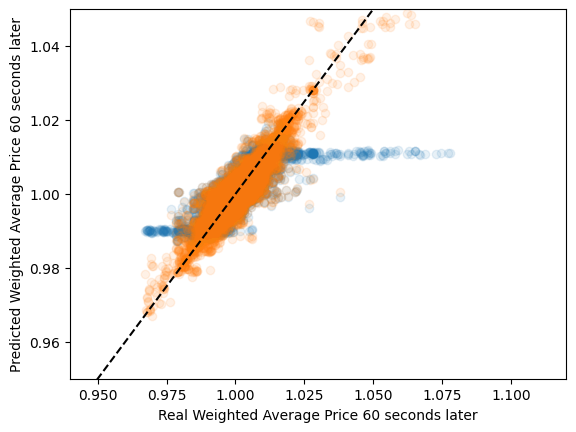

In [92]:
plt.scatter(y_val, xgb_r.predict(x_val), alpha=0.1)
plt.scatter(y_val, lr.predict(x_val), alpha=0.1)

plt.plot([-1,2],[-1,2], color='black', ls='--')
plt.xlim(0.94, 1.12)
plt.ylim(0.95,1.05)
plt.xlabel('Real Weighted Average Price 60 seconds later')
plt.ylabel('Predicted Weighted Average Price 60 seconds later')

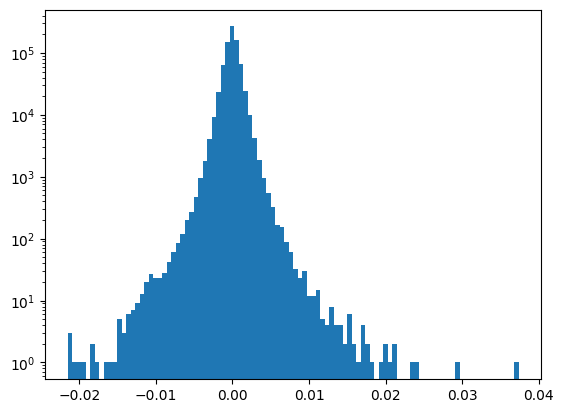

In [88]:
plt.hist(y_val - lr.predict(x_val), bins=100)
plt.yscale('log')